<a href="https://colab.research.google.com/github/chrisfilo/experiments/blob/master/(Deep)_Neural_Nets_and_basic_logic_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training simple neural nets to perform AND, OR, and XOR operations with Keras

Back in the days, before the era of deep learning neural nets trained on GPUs, simple logical operations were oftern use to teach basics of artificial neural nets (perceptrons) and backpropagation. I thought it would be fun and educational to revist these topics with modern libraries such as Keras. Afterall deep understanding of simple systems can translated to better insights into complex multilayer networks.

## Logical OR
Will start with a logical OR. As a reminder for two inputs we will get one output according to this rule:

```
0 0 -> 0
0 1 -> 1
1 0 -> 1
1 1 -> 1
```

Let's start with generating the training data

In [0]:
import numpy as np
binary_pairs = np.random.choice([0,1], [100,2])
or_output = np.logical_or(binary_pairs[:,0], binary_pairs[:,1]).astype(int)
print(binary_pairs.shape)
print(or_output.shape)

(100, 2)
(100,)


We will start with a very simple model. A single dense (fully connected) layer 
with one unit. Basically this is equivalent to a single artificial neuron. We will further minimize the
number of trainable parameters by skipping the bias factor.

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def get_model1():
  model1 = Sequential()
  model1.add(Dense(1, activation='sigmoid', input_shape=(2,), use_bias=False))
  model1.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.01),
                metrics=['accuracy'])
  return model1

get_model1().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


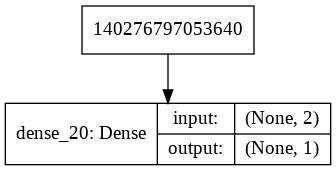

In [0]:
from keras.utils import plot_model
from IPython.display import Image

def plot_model_notebook(model):
  plot_model(model, show_shapes=True, to_file='model1.png')
  return Image(filename='model1.png')
  
plot_model_notebook(get_model1())

Now that the network is define lets train it and check the results.

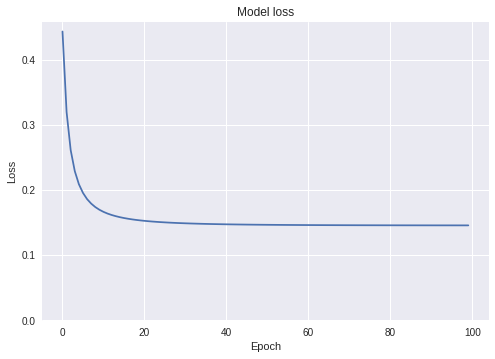

In [0]:
import pylab as plt
def fit_and_plot(model, X, y):
  history = model.fit(X, y, epochs=100, batch_size=1, verbose=0)
  plt.plot(history.history['loss'])
  plt.ylim([-0.001, plt.ylim()[1]])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()
  
  return model
  
trained_model1_or = fit_and_plot(get_model1(), binary_pairs, or_output)

As you can see training the network does not lead to zero loss. Something is wrong. Lets check the all four combinations of inputs to see how the network perfoms.

In [0]:
trained_model1_or.predict(np.array([[0,0],[0,1], [1,0], [1,1]]))

array([[0.5       ],
       [0.99988115],
       [0.99979   ],
       [1.        ]], dtype=float32)

Outputs ar roughly correct for `0 1`, `1 0`, and  `1 1`inputs, but quite off for `0 0`. Lets investigate the weights to see what's going on.

In [0]:
for layer in trained_model1_or.layers:
  print(layer.name)
  print(layer.get_weights())

dense_21
[array([[8.582448],
       [9.23152 ]], dtype=float32)]


There are two positive weights for the two inputs. This will lead to input of the activation function to be `>1` for `0 1`,  and `1 0` and `1 1` which translates to a correct output of `~1`. However, for `0 0` the input to the activation function will be `0` leading to `0.5` output. Wee need an offset to translate keep this `0` after applying the activation function. Lets create a model with a trainable offset/bias parameter.

In [0]:
def get_model2():
  model2 = Sequential()
  model2.add(Dense(1, activation='sigmoid', input_shape=(2,), use_bias=True))
  model2.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.01),
                metrics=['accuracy'])
  return model2

get_model2().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


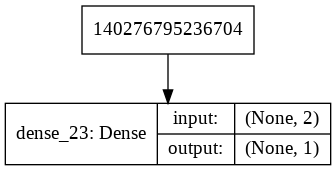

In [0]:
plot_model_notebook(get_model2())

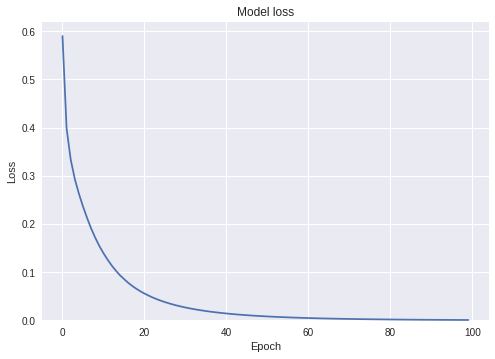

In [0]:
trained_model2_or = fit_and_plot(get_model2(), binary_pairs, or_output)

In [0]:
trained_model2_or.predict(np.array([[0,0],[0,1], [1,0], [1,1]]))

array([[0.00174917],
       [0.9997861 ],
       [0.9995395 ],
       [1.        ]], dtype=float32)

The new model minimizes the loss to almost zero and gives correct answers! Lets see what value did the bias factor get.

In [0]:
for layer in trained_model2_or.layers:
  print(layer.get_weights())

[array([[14.060149],
       [13.798986]], dtype=float32), array([-6.1880016], dtype=float32)]


Bias factor was trained to a negative value effectively offseting the center of the activation function. Finally zeros remain zeros!

Lets see if this architecture can learn how to perform logical AND.

## Logical AND

In [0]:
and_output = np.logical_and(binary_pairs[:,0], binary_pairs[:,1]).astype(int)

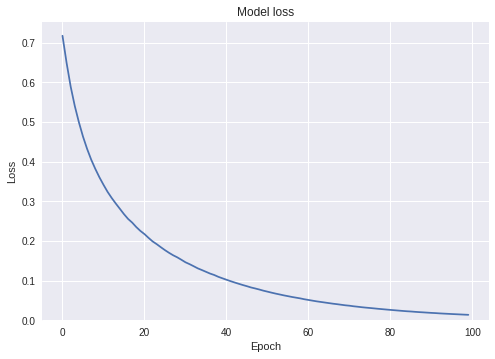

In [0]:
trained_model2_and = fit_and_plot(get_model2(), binary_pairs, and_output)

In [0]:
trained_model2_and.predict(np.array([[0,0],[0,1], [1,0], [1,1]]))

array([[5.3581284e-06],
       [1.6192757e-02],
       [1.6182886e-02],
       [9.8059332e-01]], dtype=float32)

In [0]:
for layer in trained_model2_and.layers:
  print(layer.name)
  print(layer.get_weights())

dense_25
[array([[8.029405],
       [8.030025]], dtype=float32), array([-12.13689], dtype=float32)]


No problems! Close to zero loss and correct answer. Notice that the trained weights are similar to OR. The main difference is that for AND the absolute value of the offset is larger than the absolute value of any single weight. Thus to reach activation (`output == 1`) both inputs need to be set to `1` to overcome the offset (instead of only one in case of OR).

Final challenge - lets see if this will cope with XOR.

## Logical XOR

In [0]:
xor_output = np.logical_xor(binary_pairs[:,0], binary_pairs[:,1]).astype(int)

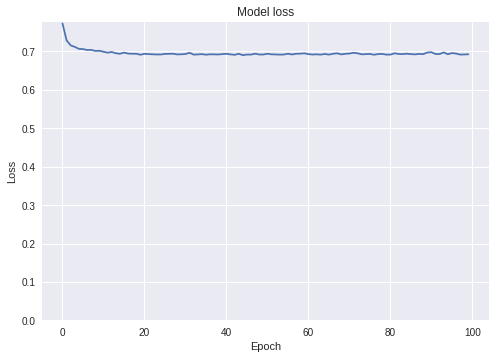

In [0]:
trained_model2_xor = fit_and_plot(get_model2(), binary_pairs, xor_output)

In [0]:
trained_model2_xor.predict(np.array([[0,0],[0,1], [1,0], [1,1]]))

array([[0.610229  ],
       [0.602673  ],
       [0.48691767],
       [0.47901198]], dtype=float32)

This does not look great. Loss is not even near zero and results look pretty random. This is because the XOR operation is not linearly separable (see this [post](https://medium.com/@jayeshbahire/the-xor-problem-in-neural-networks-50006411840b) for more in depth explanation). To solve non-linear problems like XOR we need more than one layer. Lets construct a deeper network:

In [0]:
def get_model3():
  model3 = Sequential()
  model3.add(Dense(2, activation='sigmoid', input_shape=(2,), use_bias=True))
  model3.add(Dense(1, activation='sigmoid'))
  model3.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.01),
                metrics=['accuracy'])
  return model3

get_model3().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


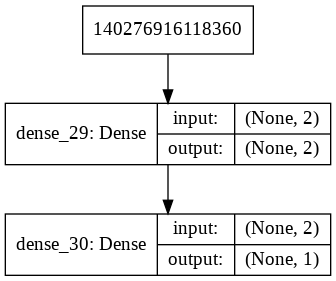

In [0]:
plot_model_notebook(get_model3())

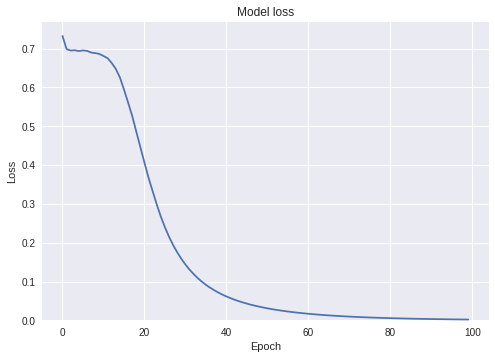

In [0]:
trained_model3_xor = fit_and_plot(get_model3(), binary_pairs, xor_output)

In [0]:
trained_model3_xor.predict(np.array([[0,0],[0,1], [1,0], [1,1]]))

array([[0.00316234],
       [0.99859256],
       [0.9983375 ],
       [0.00263315]], dtype=float32)

Success! Zero loss and sensible outputs! Lets see how the network does it!

In [0]:
for layer in trained_model3_xor.layers:
  print(layer.name)
  print(layer.get_weights())

dense_31
[array([[  8.267677, -11.535341],
       [ -9.558922,   9.911973]], dtype=float32), array([-4.288592 , -5.1230717], dtype=float32)]
dense_32
[array([[12.628891],
       [12.668411]], dtype=float32), array([-5.99928], dtype=float32)]


The neurons in the first layer detect `1 0` and `0 1` respectively. The neuron in the second layer practically performs an OR operation on the outputs of neurons from the first layer.

Problem solved, but is the new architecture specific to the XOR problem or can it still solve OR and AND? Lets check.

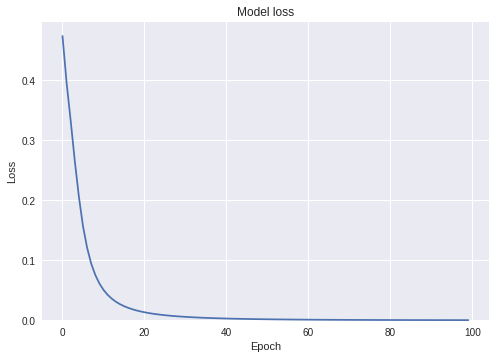

In [0]:
trained_model3_or = fit_and_plot(get_model3(), binary_pairs, or_output)

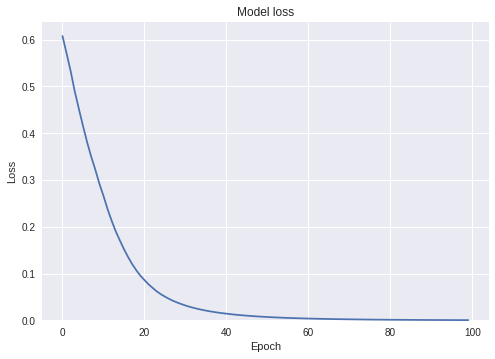

In [0]:
trained_model3_and = fit_and_plot(get_model3(), binary_pairs, and_output)

No problems. The architecture generalizes to all three operations.

## Summary
Working with trivial examples such as logical operations has some advantages. In contrast to complex models we can interrogate and understand individual weights and thus get a better grasp of the system.

If you have comments or suggestions regarding this notebook don't hesitate to open and []issue](https://github.com/chrisfilo/experiments/issues) or send a []pull request](https://github.com/chrisfilo/experiments/pulls).